In [9]:
#-- Packages --#

#--- Operational ---#
import os
import sys 
import pandas as pd
import numpy as np
import geopandas as gpd
from pathlib import Path
import json
import re
import geopandas as gpd

#--- Visualisations ---#
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from shapely.geometry import Point

#-- Directories --#
nb_dir = Path.cwd()
REPO_ROOT = nb_dir.parent
data_dir = REPO_ROOT / 'data/'
processed_dir = data_dir / 'processed/'
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

In [10]:
print(f'Loading severe burns shapefiles...')
severe_burn_file = REPO_ROOT / 'data/processed/severe_burns/Brandywine_big_severe_patches.shp'
severe_burn = gpd.read_file(severe_burn_file)
print(f'Severe Burns loaded. {severe_burn.crs}\n')

print(f'Loading all Brandywine burns shapefiles...')
brandywine_burn_file = REPO_ROOT / 'data/processed/subregion_fires/Brandywine_fires_shp_files/Brandywine_fires_shp_files.shp'
brandywine = gpd.read_file(brandywine_burn_file)
print(f'Brandywine Burns loaded. {brandywine.crs}\n')


print(f'Loading Avalanche Canada (AvCan) regions shapefile...')
avcan_path = REPO_ROOT / "data/processed/avalanche_canada/AvCan_cleaned_subregions.geojson"
avcan= gpd.read_file(avcan_path)
print(f" Avalanche Canada Regions loaded. {avcan.crs}\n")

Loading severe burns shapefiles...
Severe Burns loaded. EPSG:4326

Loading all Brandywine burns shapefiles...
Brandywine Burns loaded. EPSG:4326

Loading Avalanche Canada (AvCan) regions shapefile...
 Avalanche Canada Regions loaded. EPSG:4326



/var/folders/bs/_y1b6rb96rb21tm4p3r5fpz80000gn/T/ipykernel_91708/3505375717.py:27: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


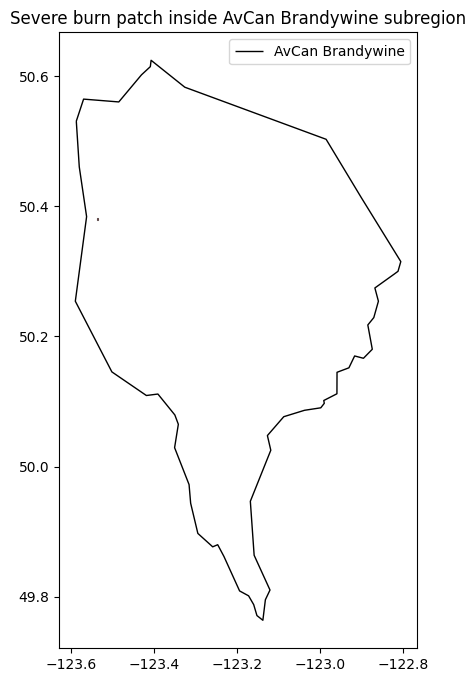

In [11]:

# 2. Filter to the AvCan region / subregion you care about --
# e.g. Brandywine subregion in Sea To Sky region
avcan_sel = avcan[avcan["subregion"] == "Brandywine"].copy()

# 3. Make sure CRS match  -----------------------------------
if avcan_sel.crs != severe_burn.crs:
    severe_burn = severe_burn.to_crs(avcan_sel.crs)

# 4. Plot overlay  ------------------------------------------
fig, ax = plt.subplots(figsize=(8, 8))

# AvCan subregion outline
avcan_sel.boundary.plot(ax=ax, color="black", linewidth=1, label="AvCan Brandywine")

# Severe burn patch
severe_burn.plot(
    ax=ax,
    color="red",
    alpha=0.6,
    edgecolor="k",
    linewidth=0.8,
    label="Severe burn patch (≥5 ha cluster)",
    
)

ax.set_title("Severe burn patch inside AvCan Brandywine subregion")
ax.legend()
plt.show()


In [12]:
brandywine.columns

Index(['gid', 'fireid', 'year', 'natpark', 'tot_adj_ha', 'cause', 'region',
       'subregion', 'prov_terr', 'subreg_ha', 'geometry'],
      dtype='object')

In [13]:
brandywine = brandywine.rename(columns={
    "year":"Year",
    "tot_adj_ha":"Total Adjusted Area (ha)",
    "region":"Region",
    "subregion":"Subregion",
    'gid':'Unique Fire ID (gid)'
})

brandywine['Total Adjusted Area (ha)'] = brandywine['Total Adjusted Area (ha)'].round(2)


gid211 = brandywine[brandywine['Unique Fire ID (gid)'] == '2024_211']

gid211

,Unique Fire ID (gid),fireid,Year,natpark,Total Adjusted Area (ha),cause,Region,Subregion,prov_terr,subreg_ha,geometry
0,2024_211,211,2024,None,466.77,Natural,Sea To Sky,Brandywine,British Columbia,459.028195,"POLYGON ((-123.54570 50.38889, -123.54557 50.3..."


In [14]:
severe_burn = severe_burn.rename(columns={
    "slp_mn_pct": "Slope mean (%)",
    "elev_mean_": "Mean elevation (m)",
    "elev_max_m": "Max elevation (m)",
    'aspect_car': "Aspect",
    'patch_area': "Severe burn area (ha)",
    'gid':'Unique Fire ID (gid)',
    'year':'Year'
    # ...
})
severe_burn['Slope mean (%)'] = severe_burn['Slope mean (%)'].round(2)
severe_burn['Mean elevation (m)'] = severe_burn['Mean elevation (m)'].round(2)
severe_burn['Severe burn area (ha)'] = severe_burn['Severe burn area (ha)'].round(2)


In [15]:
# centre on all severe_burn patches
centroid = severe_burn.geometry.unary_union.centroid
center = [centroid.y, centroid.x]   # [lat, lon]

m = avcan_sel.explore(
    tiles="OpenTopoMap",  # or "OpenStreetMap", "Stamen Terrain", ...
    style_kwds=dict(color="black", weight=1, fill=False),
    name="AvCan Brandywine",
    location=center,   # <- initial centre
    zoom_start=14,     # <- tweak until it feels right
    width=900,
    height=600,
)

# fire_cols = ["Unique Fire ID (gid)","Year","Total Adjusted Area (ha)","Region","Subregion"]

# gid211.explore(
#     m=m,
#     color="white",
#     name="Fire Polygon",
#     tooltip=fire_cols,
#     popup=fire_cols
# )

severe_cols = ["Unique Fire ID (gid)", "Year", "Aspect","Severe burn area (ha)", "Mean elevation (m)","Slope mean (%)"]  # whatever you want visible
severe_burn.explore(
    m=m,
    color="red",
    name="Severe burn patch",
    tooltip=severe_cols,   # shown on hover
    popup=severe_cols      # shown on click
    
)

m  # show map


In [16]:
m.save("brandywine_severe_burn.html")